In [1]:
import sys

import pandas as pd
import mplfinance as mpl

sys.path.append("../../")
sys.path.append(".")

from strategy import LongStrategy, ShortStrategy
from triple_barrier.trading import DataSetLabeler
from triple_barrier.trade_labeling import TradeSide
from triple_barrier.trading import TradingParameters

from triple_barrier.plots import PlotTripleBarrier
from triple_barrier.trade_labeling import Labeler
from triple_barrier.orders import Orders



# Constants

In [2]:
FAST_PERIODS: int = 10
COLUMNS = ["date-time", "open", "high", "low", "close", "volume"]
SLOW_PERIODS: int = 20
PIP_DECIMAL_POSITION = 4

# Using triple barrier from pandas apply

The following examples show how to use triple barrier to massively label trades using as input a pandas dataframe that contains enty and eventually custom exit signals.

This shows als how to plot with the plotting wrapper, which simplifies the plotting passing only the date for the trade to plot and some other related parameters.


## Trading Strategy

In this section is described how to implement a simple trading strategy that generates the inputs for triple_barrier.

- The calculations are performed on a OHLC time series.
- The price used is FOREX and for now the triple barrier is tested onbly on forex price.


The strategy is as follows:

1. Two moving averages are calculated: 10 periods ( called FAST ), the fast one, and 20 periods one (called SLOW) the slow one
2. A long signal is recorded for a bar after the closing if the following condition is met: FAST crosses above SLOW. More precisely:

$FAST_{t-1} < SLOW_{t-1} \land FAST_t > SLOW_t$

Where:

- $t-1$: period previous to the current closing
- $t$: current closing period

3. A short signal is recorded for a bar after the closing if the following condition is met FAST crosses below SLOW. More precisely:

$FAST_{t-1} > SLOW_{t-1} \land FAST_t < SLOW_t$

Where:

- $t-1$: period previous to the current closing
- $t$: current closing period


Notes

The entry period, when the position is opened, is the period right after the signal, the position open price is the open price for this bar.

Position opening price = $open_t$

For closing there will be a few cases that will be setup using the triple barrier and will be described in the caseses next. One of the closing cases is closing when the entry condition is not valid anymore and is described next.


4. Long closing: FAST < SLOW
5. Short closing: FAST > SLOW


## Trading Cases

### Long Strategy

This case illustrates the situation when 

#### Vectorized Trade  Labeling

In [3]:
STOP_LOSS_WIDTH = 10
TAKE_PROFIT_WIDTH = 20
TRADE_PERIODS = 2

In [4]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [5]:
long_strategy = LongStrategy(pip_position=4, fast_periods=10, slow_periods=20)
long_strategy.calculate(price)
price.head()

,open,high,low,close,volume,mva-10,mva-20,awo,long-signal,long-entry,long-signal-plot,long-entry-plot,long-close-signal,long-close-exit,long-close-signal-plot,long-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,0.00023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,0.00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
price.loc["2023-01-02 14:25:00":"2023-01-02 14:45:00"]

,open,high,low,close,volume,mva-10,mva-20,awo,long-signal,long-entry,long-signal-plot,long-entry-plot,long-close-signal,long-close-exit,long-close-signal-plot,long-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 14:25:00,1.06609,1.06621,1.06606,1.06610,322.26,1.06587,1.06595,-0.00008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:30:00,1.06610,1.06614,1.06601,1.06608,237.61,1.06593,1.06593,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:35:00,1.06608,1.06618,1.06607,1.06610,117.80,1.06600,1.06593,0.00007,1.0,NaN,1.06557,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,189.59,1.06604,1.06592,0.00012,NaN,1.0,NaN,1.06561,NaN,NaN,NaN,NaN
2023-01-02 14:45:00,1.06613,1.06617,1.06605,1.06613,215.13,1.06609,1.06590,0.00019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the table above, you can see an examplem of FAST crossing above SLOW, which triggers a long signal and marks the next bar as long entry

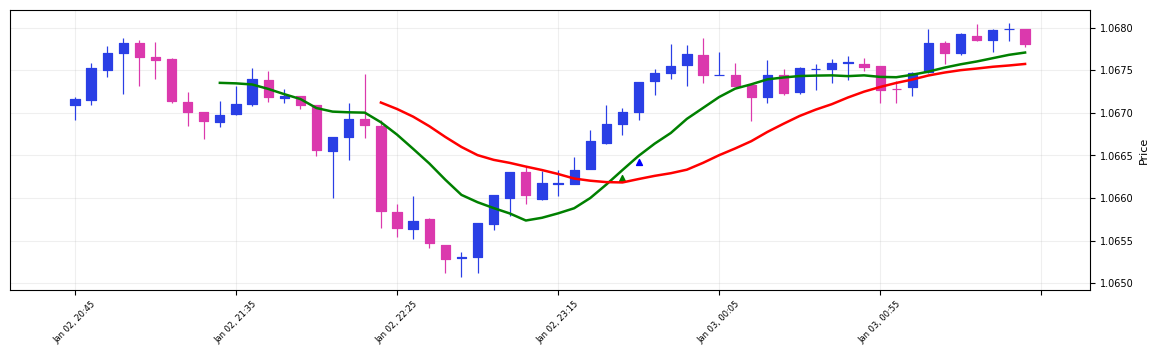

In [7]:
ap0 = [ mpl.make_addplot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"]['long-signal-plot'],color='g', marker="^", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"]['long-entry-plot'],color='b', marker="^", type="scatter"),]  # uses panel 0 by default 

mpl.plot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [8]:
trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["long-entry"],
    stop_loss_width=STOP_LOSS_WIDTH,
    take_profit_width=TAKE_PROFIT_WIDTH,
    trade_side=TradeSide.BUY,
    pip_decimal_position=PIP_DECIMAL_POSITION,
    time_barrier_periods=TRADE_PERIODS,
    dynamic_exit=None
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [9]:
trades.head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,1.0,1.06611,2023-01-02 14:50:00,time-expiration,0.0
2023-01-02 17:00:00,1.06601,1.06626,1.06577,1.06600,1.0,1.06620,2023-01-02 17:10:00,time-expiration,1.9
2023-01-02 20:05:00,1.06810,1.06840,1.06805,1.06810,1.0,1.06710,2023-01-02 20:10:00,stop-loss,-10.0
2023-01-02 20:40:00,1.06696,1.06747,1.06693,1.06713,1.0,1.06715,2023-01-02 20:50:00,time-expiration,1.9
2023-01-02 23:40:00,1.06701,1.06736,1.06692,1.06736,1.0,1.06747,2023-01-02 23:50:00,time-expiration,4.6


<Axes: xlabel='date-time'>

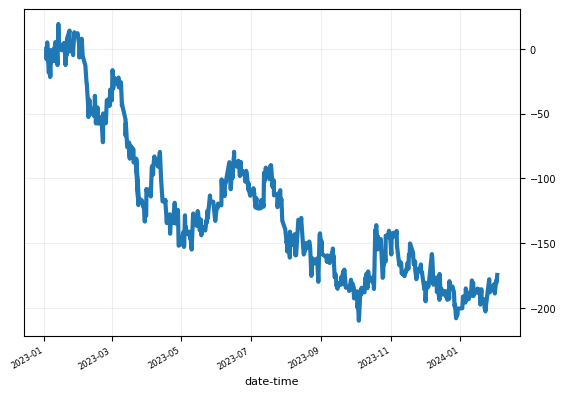

In [10]:
trades["profit"].cumsum().plot()

#### Visually check for one trade

#### Plot with wrapper

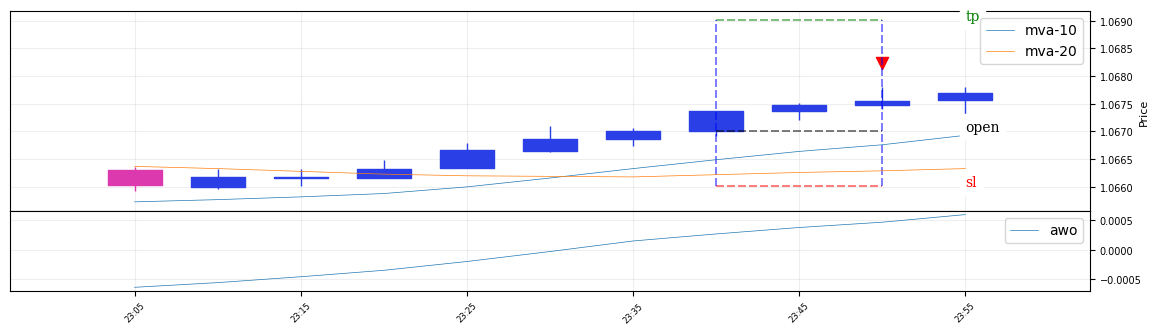

In [11]:
dataset_labeler.plot("2023-01-02 23:40:00", 
                     overlay_features=[price["mva-10"], price["mva-20"]], 
                     oscillator_features=[price["awo"]],
                     periods_before=7,
                     periods_after=1)

### Short Strategy

#### Vectorized Trade Labeling

In [12]:
STOP_LOSS_WIDTH = 20
TAKE_PROFIT_WIDTH = 40
TRADE_PERIODS = 10

In [13]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [14]:
long_strategy = ShortStrategy(pip_position=4, fast_periods=10, slow_periods=20)
long_strategy.calculate(price)
price.head()

,open,high,low,close,volume,mva-10,mva-20,awo,short-signal,short-entry,short-signal-plot,short-entry-plot,short-close-signal,short-close-exit,short-close-signal-plot,short-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,0.00023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,0.00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
range_from = "2023-01-02 13:00:00"
range_to = "2023-01-02 16:00:00"

In [16]:
price.loc[range_from:range_to].tail(10)

,open,high,low,close,volume,mva-10,mva-20,awo,short-signal,short-entry,short-signal-plot,short-entry-plot,short-close-signal,short-close-exit,short-close-signal-plot,short-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 15:15:00,1.06573,1.06582,1.06570,1.06573,204.30,1.06601,1.06594,0.00007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:20:00,1.06573,1.06575,1.06549,1.06550,45.00,1.06595,1.06594,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:25:00,1.06553,1.06573,1.06532,1.06533,68.46,1.06587,1.06593,-0.00006,1.0,NaN,1.06623,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,44.11,1.06581,1.06593,-0.00012,NaN,1.0,NaN,1.06624,NaN,NaN,NaN,NaN
2023-01-02 15:35:00,1.06550,1.06556,1.06537,1.06551,69.06,1.06575,1.06592,-0.00017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:40:00,1.06550,1.06550,1.06534,1.06536,8.21,1.06567,1.06588,-0.00021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:45:00,1.06536,1.06542,1.06534,1.06542,4.61,1.06560,1.06584,-0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:50:00,1.06542,1.06542,1.06536,1.06540,22.93,1.06554,1.06581,-0.00027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:55:00,1.06540,1.06540,1.06532,1.06533,21.96,1.06548,1.06578,-0.00030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


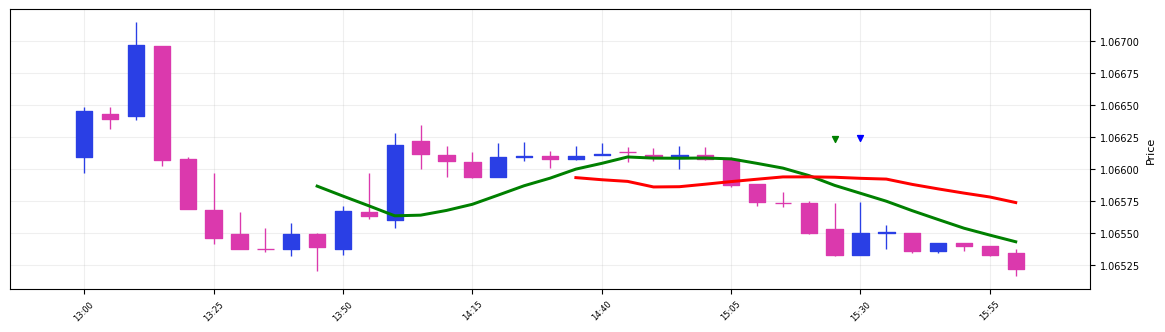

In [17]:
ap0 = [ mpl.make_addplot(price.loc[range_from:range_to]['short-signal-plot'],color='g', marker="v", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['short-entry-plot'],color='b', marker="v", type="scatter"),]  # uses panel 0 by default 

mpl.plot(price.loc[range_from:range_to], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [18]:
trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["short-entry"],
    stop_loss_width=STOP_LOSS_WIDTH,
    take_profit_width=TAKE_PROFIT_WIDTH,
    trade_side=TradeSide.SELL,
    pip_decimal_position=PIP_DECIMAL_POSITION,
    time_barrier_periods=TRADE_PERIODS,
    dynamic_exit=None
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [19]:
trades.head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-02 02:25:00,1.06939,1.06976,1.06939,1.06961,1.0,1.06967,2023-01-02 03:15:00,time-expiration,-2.8
2023-01-02 10:10:00,1.06827,1.06834,1.06795,1.06830,1.0,1.06796,2023-01-02 11:00:00,time-expiration,3.1
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,1.0,1.06529,2023-01-02 16:20:00,time-expiration,0.4
2023-01-02 22:05:00,1.06655,1.06672,1.06600,1.06672,1.0,1.06569,2023-01-02 22:55:00,time-expiration,8.6
2023-01-03 02:10:00,1.06675,1.06698,1.06675,1.06681,1.0,1.06639,2023-01-03 03:00:00,time-expiration,3.6


<Axes: xlabel='date-time'>

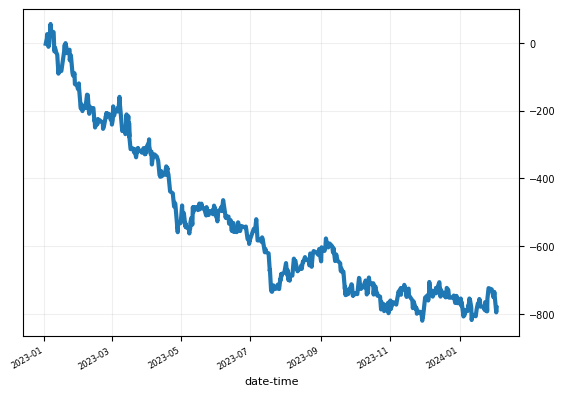

In [20]:
trades["profit"].cumsum().plot()

#### Visual check for one trade

#### Plot with wrapper

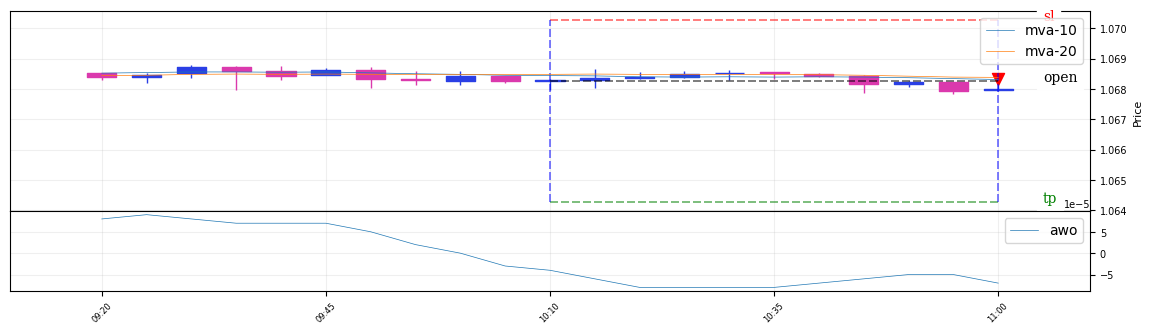

In [21]:
dataset_labeler.plot("2023-01-02 10:10:00", 
                     overlay_features=[price["mva-10"], price["mva-20"]],
                     oscillator_features=[ price["awo"]],
                     periods_before=10,
                     periods_after=0)

## Long Strategy with Dynamic Exit

In this case the strategies will exit mainly depending on a dynamic exit condition and not because of stop-loss, take-profit or time barrier hit.

A dynamic condition is a condition calculated as a function of indicators, price action or whatever feature or feature combination you decide to use.

In this case the exit conditions, already mentioned in the strategy definition, are the following:

Exit from long positions: FAST < SLOW
Exit from short positions: FAST > SLOW

To control that most of the exits are due to dynamic condition, the stop-loss, take-profit and trading periods for time barrier will be set to high values:

Take Profit: 100 pips
Stop Loss: 50
Trading periods: 100 periods


### Long Strategy

#### Vectirized Trade Labeling

In [22]:
STOP_LOSS_WIDTH = 50
TAKE_PROFIT_WIDTH = 100
TRADE_PERIODS = 50

In [23]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [24]:
long_strategy = LongStrategy(pip_position=4, fast_periods=10, slow_periods=20)
long_strategy.calculate(price)
price.head()

,open,high,low,close,volume,mva-10,mva-20,awo,long-signal,long-entry,long-signal-plot,long-entry-plot,long-close-signal,long-close-exit,long-close-signal-plot,long-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,0.00023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,0.00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
range_from = "2023-01-02 12:35:00"
range_to = "2023-01-02 16:00:00"
price[range_from:range_to].tail(20)

,open,high,low,close,volume,mva-10,mva-20,awo,long-signal,long-entry,long-signal-plot,long-entry-plot,long-close-signal,long-close-exit,long-close-signal-plot,long-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 14:25:00,1.06609,1.06621,1.06606,1.06610,322.26,1.06587,1.06595,-0.00008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:30:00,1.06610,1.06614,1.06601,1.06608,237.61,1.06593,1.06593,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:35:00,1.06608,1.06618,1.06607,1.06610,117.80,1.06600,1.06593,0.00007,1.0,NaN,1.06557,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,189.59,1.06604,1.06592,0.00012,NaN,1.0,NaN,1.06561,NaN,NaN,NaN,NaN
2023-01-02 14:45:00,1.06613,1.06617,1.06605,1.06613,215.13,1.06609,1.06590,0.00019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:50:00,1.06611,1.06616,1.06606,1.06610,298.60,1.06608,1.06586,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 14:55:00,1.06610,1.06618,1.06600,1.06611,515.85,1.06608,1.06586,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:00:00,1.06611,1.06617,1.06607,1.06608,256.09,1.06608,1.06588,0.00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:05:00,1.06608,1.06609,1.06586,1.06587,381.89,1.06608,1.06590,0.00018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


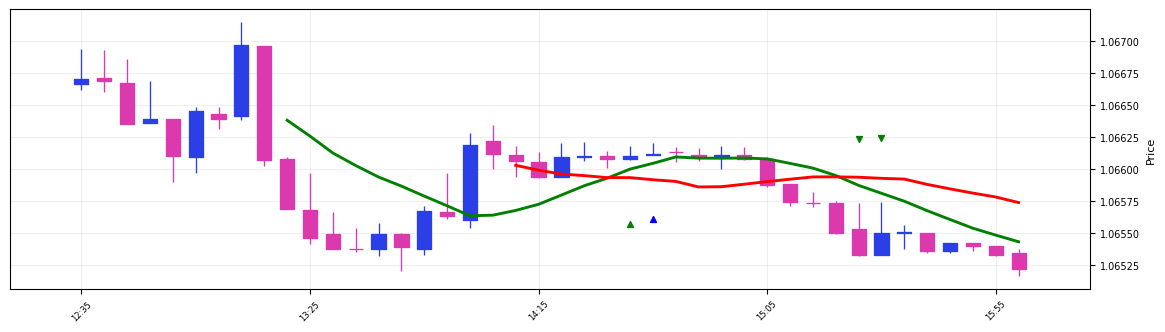

In [26]:
ap0 = [ mpl.make_addplot(price.loc[range_from:range_to]['long-signal-plot'],color='g', marker="^", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['long-entry-plot'],color='b', marker="^", type="scatter"),
        mpl.make_addplot(price.loc[range_from:range_to]['long-close-signal-plot'],color='g', marker="v", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['long-close-exit-plot'],color='g', marker="v", type="scatter"),
      ]  # uses panel 0 by default 

mpl.plot(price.loc[range_from:range_to], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [27]:
trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["long-entry"],
    stop_loss_width=STOP_LOSS_WIDTH,
    take_profit_width=TAKE_PROFIT_WIDTH,
    trade_side=TradeSide.BUY,
    pip_decimal_position=PIP_DECIMAL_POSITION,
    time_barrier_periods=TRADE_PERIODS,
    dynamic_exit=price["long-close-exit"]
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [28]:
trades.head()

,open,high,low,close,entry,exit,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,,
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,1.0,NaN,1.06550,2023-01-02 15:30:00,dynamic,-6.1
2023-01-02 17:00:00,1.06601,1.06626,1.06577,1.06600,1.0,NaN,1.06680,2023-01-02 19:00:00,dynamic,7.9
2023-01-02 20:05:00,1.06810,1.06840,1.06805,1.06810,1.0,NaN,1.06770,2023-01-02 20:55:00,dynamic,-4.0
2023-01-02 20:40:00,1.06696,1.06747,1.06693,1.06713,1.0,NaN,1.06770,2023-01-02 20:55:00,dynamic,7.4
2023-01-02 23:40:00,1.06701,1.06736,1.06692,1.06736,1.0,NaN,1.06682,2023-01-03 02:10:00,dynamic,-1.9


<Axes: xlabel='date-time'>

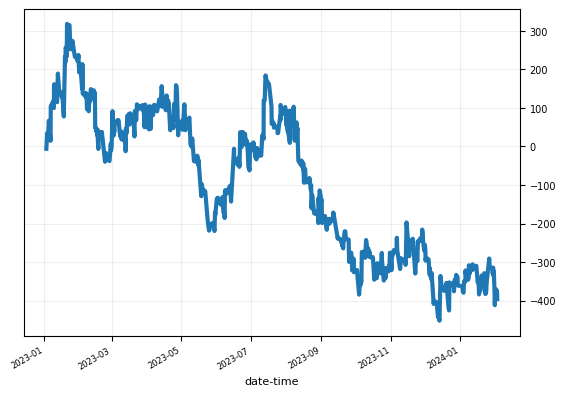

In [29]:
trades["profit"].cumsum().plot()

#### Visual check for one trade

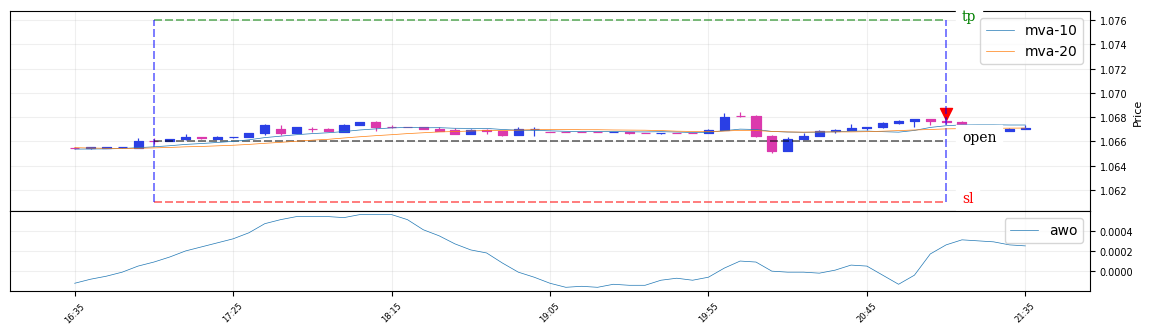

In [30]:
dataset_labeler.plot("2023-01-02 17:00:00", overlay_features=[price["mva-10"], price["mva-20"]],oscillator_features=[ price["awo"]])

### Short Strategy

#### Vectorized trade labeling

In [31]:
STOP_LOSS_WIDTH = 50
TAKE_PROFIT_WIDTH = 100
TRADE_PERIODS = 50

In [32]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [33]:
long_strategy = ShortStrategy(pip_position=4, fast_periods=10, slow_periods=20)
long_strategy.calculate(price)
price.head()

,open,high,low,close,volume,mva-10,mva-20,awo,short-signal,short-entry,short-signal-plot,short-entry-plot,short-close-signal,short-close-exit,short-close-signal-plot,short-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,0.00025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,0.00023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,0.00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
range_from = "2023-01-02 12:00:00"
range_to = "2023-01-02 17:00:00"
price[range_from:range_to].tail(20)

,open,high,low,close,volume,mva-10,mva-20,awo,short-signal,short-entry,short-signal-plot,short-entry-plot,short-close-signal,short-close-exit,short-close-signal-plot,short-close-exit-plot
date-time,,,,,,,,,,,,,,,,
2023-01-02 15:25:00,1.06553,1.06573,1.06532,1.06533,68.46,1.06587,1.06593,-0.00006,1.0,NaN,1.06623,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,44.11,1.06581,1.06593,-0.00012,NaN,1.0,NaN,1.06624,NaN,NaN,NaN,NaN
2023-01-02 15:35:00,1.06550,1.06556,1.06537,1.06551,69.06,1.06575,1.06592,-0.00017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:40:00,1.06550,1.06550,1.06534,1.06536,8.21,1.06567,1.06588,-0.00021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:45:00,1.06536,1.06542,1.06534,1.06542,4.61,1.06560,1.06584,-0.00024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:50:00,1.06542,1.06542,1.06536,1.06540,22.93,1.06554,1.06581,-0.00027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 15:55:00,1.06540,1.06540,1.06532,1.06533,21.96,1.06548,1.06578,-0.00030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 16:00:00,1.06534,1.06537,1.06516,1.06522,72.29,1.06543,1.06574,-0.00031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 16:05:00,1.06522,1.06541,1.06520,1.06534,118.72,1.06539,1.06570,-0.00031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


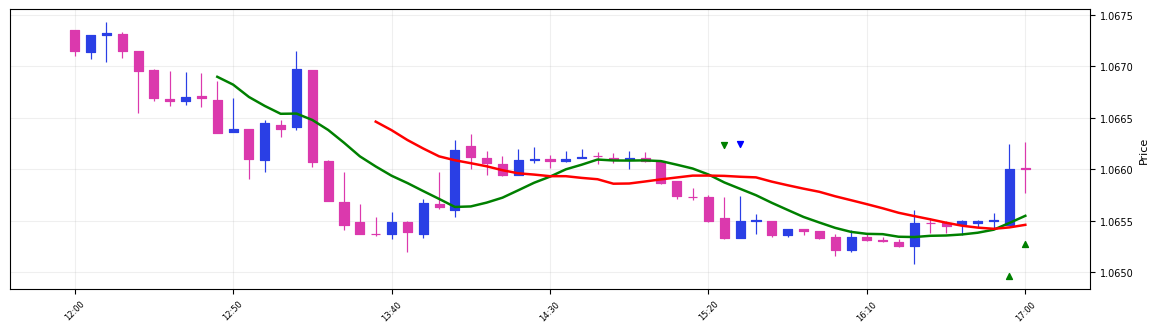

In [35]:
ap0 = [ mpl.make_addplot(price.loc[range_from:range_to]['short-signal-plot'],color='g', marker="v", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['short-entry-plot'],color='b', marker="v", type="scatter"),
        mpl.make_addplot(price.loc[range_from:range_to]['short-close-signal-plot'],color='g', marker="^", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['short-close-exit-plot'],color='g', marker="^", type="scatter"),
      ]  # uses panel 0 by default 

mpl.plot(price.loc[range_from:range_to], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [36]:
trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["short-entry"],
    stop_loss_width=STOP_LOSS_WIDTH,
    take_profit_width=TAKE_PROFIT_WIDTH,
    trade_side=TradeSide.SELL,
    pip_decimal_position=PIP_DECIMAL_POSITION,
    time_barrier_periods=TRADE_PERIODS,
    dynamic_exit=price["short-close-exit"]
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [37]:
trades.head()

,open,high,low,close,entry,exit,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,,
2023-01-02 02:25:00,1.06939,1.06976,1.06939,1.06961,1.0,NaN,1.06801,2023-01-02 05:55:00,dynamic,13.8
2023-01-02 10:10:00,1.06827,1.06834,1.06795,1.06830,1.0,NaN,1.06594,2023-01-02 14:20:00,time-expiration,23.3
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,1.0,NaN,1.06601,2023-01-02 17:00:00,dynamic,-6.8
2023-01-02 22:05:00,1.06655,1.06672,1.06600,1.06672,1.0,NaN,1.06737,2023-01-02 23:40:00,dynamic,-8.2
2023-01-03 02:10:00,1.06675,1.06698,1.06675,1.06681,1.0,NaN,1.05675,2023-01-03 05:30:00,take-profit,100.0


<Axes: xlabel='date-time'>

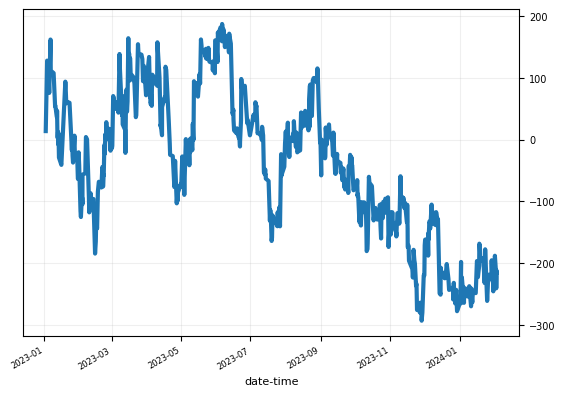

In [38]:
trades["profit"].cumsum().plot()

#### Visual check for one trade

In [39]:
box_setup = Orders()

box_setup.open_time = "2023-01-02 02:25:00"
box_setup.open_price = price.loc[box_setup.open_time]["open"]
box_setup.take_profit_width = TAKE_PROFIT_WIDTH
box_setup.stop_loss_width = STOP_LOSS_WIDTH
box_setup.time_limit = price[box_setup.open_time:].index[TRADE_PERIODS]
box_setup.trade_side = TradeSide.SELL
box_setup.pip_decimal_position = PIP_DECIMAL_POSITION


print(box_setup)

trade_labeler = Labeler(open_price=price.open,
                               high_price=price.high,
                               low_price=price.low,
                               close_price=price.close,
                               box_setup=box_setup,
                               dynamic_exit=price["short-close-exit"])
orders_hit = trade_labeler.compute()
print(orders_hit)

plot_tb = PlotTripleBarrier(price.open,
                           price.high,
                           price.low,
                           price.close,
                           4,
                           periods_to_plot=55,
                           overlay_features=[ price["mva-10"], price["mva-20"] ]
                           )

plot_tb.plot_multi_barrier(trade_labeler)


        open time: 2023-01-02 02:25:00
        open price: 1.06939
        trade side: SELL
        stop loss : 50
        take profit : 100
        time limit : 2023-01-02 06:35:00
        pip position : 4
        

        
First Hit: 

        Hit type dynamic
        Hit datetime 2023-01-02 05:55:00
        "Hit price 1.06801
        
Other hits 

        Datetime: 2023-01-03 05:10:00
        Level: 1.05939
        Type: take-profit
        

        Datetime: 2023-01-09 12:15:00
        Level: 1.07439
        Type: stop-loss
        

        Datetime: 2023-01-02 06:35:00
        Level: 1.06836
        Type: time-expiration
        

        Datetime: 2023-01-02 05:55:00
        Level: 1.06801
        Type: dynamic
        


TypeError: PlotTripleBarrier.__init__() got an unexpected keyword argument 'periods_to_plot'